In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
import sklearn.datasets

In [3]:
mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")

In [4]:
class MnistDataset(Dataset):

  def __init__(self, data):
    self.data_set = data
    pass
  
  def __len__(self):
    return len(self.data_set.data)
  
  def __getitem__(self, index):
    # 이미지 목표 (레이블)
    label = self.data_set.target[index]
    # 길이는 10, 정답만 1.0으로 표시된 텐서
    target = torch.zeros((10))
    target[int(label)] = 1.0

    # 0-255의 이미지를 0-1로 정규화
    image_values = torch.FloatTensor(self.data_set.data.iloc[index].values) / 255.0

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target
  
  def plot_image(self, index):
    img = self.data_set.data.iloc[index].values.reshape(28, 28)
    plt.title("label = " + str(self.data_set.target[index]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass
  
  pass

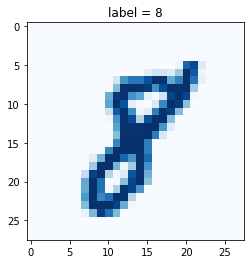

In [5]:
mnist_dataset = MnistDataset(mnist)
mnist_dataset.plot_image(17)

In [6]:
train_dataset, test_dataset = random_split(mnist_dataset, [60000, 10000])

In [7]:
# 가짜 데이터 생성
def generate_random(size):
  random_data = torch.rand(size) # 0-1사이 랜덤값
  return random_data

def generate_random_onehot(size):
  label_tensor = torch.zeros((size))
  random_idx = random.randint(0, size-1)
  label_tensor[random_idx] = 1.0
  return label_tensor

def generate_random_seed(size):
  random_data = torch.randn(size) # 평균 0, 표준편차 1인 가우시안 정규분포를 따르는 랜덤값
  return random_data

In [8]:
# 판별자 클래스
class Discriminator(nn.Module):

  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(784+10, 200),
        nn.LeakyReLU(0.02),
        
        nn.LayerNorm(200),

        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.BCELoss()

    # SGD 옵티마이저 설정
    # self.parameters() 모든 학습 파라미터
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass
  
  def forward(self, image_tensor, label_tensor):
    inputs = torch.cat((image_tensor, label_tensor))
    return self.model(inputs)
  

  def train(self, inputs, label_tensor, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs, label_tensor)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()   # 계산 그래프의 기울기 0으로 초기화
    loss.backward()   # 신경망의 기울기
    self.optimizer.step()   # 위 기울기는 이 코드를 통해서 신경망의 학습 파라미터를 갱신하는데에 사용됨

    pass
  
  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass

In [10]:
D = Discriminator()

for label, image_data_tensor, label_tensor in train_dataset:
  D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
  D.train(generate_random(784), generate_random_onehot(10), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


In [11]:
# 생성자 클래스
class Generator(nn.Module):

  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(100+10, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    # SGD 옵티마이저 설정
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass
  
  def forward(self, seed_tensor, label_tensor):
    inputs = torch.cat((seed_tensor, label_tensor))
    return self.model(inputs)
  

  def train(self, D, inputs, label_tensor, targets):
    # 신경망 출력 계산
    # 생성자 모델의 예측값
    g_output = self.forward(inputs, label_tensor)

    # 판별기로 전달
    # 생성자 모델의 예측값을 판별자 모델의 인풋으로 넣어 판별자 모델의 예측값 도출
    d_output = D.forward(g_output, label_tensor)

    # 오차 계산
    # 판별자 모델의 예측값과 라벨에 대한 손실값 도출
    loss = D.loss_function(d_output, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass
  
  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass
  
  def plot_images(self, label):
    label_tensor = torch.zeros((10))
    label_tensor[label] = 1.0

    f, axrr = plt.subplots(2, 3, figsize=(16, 8))
    for i in range(2):
      for j in range(3):
        axrr[i, j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28, 28), interpolation='none', cmap='Blues')
        pass
      pass
    pass

In [13]:
# 판별기 및 생성기 생성

D = Discriminator()
G = Generator()

# 판별기와 생성기 훈련

epochs = 12

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  for label, image_data_tensor, label_tensor in train_dataset:

    # 참에 대해 판별기 훈련
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))

    # 거짓에 대해 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    random_label = generate_random_onehot(10)
    D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))
    
    # 생성기 훈련
    random_label = generate_random_onehot(10)
    G.train(D, generate_random_seed(100), random_label, torch.FloatTensor([1.0]))

    pass
  
  pass

epoch =  1
counter =  10000
counter =  20000
counter =  10000
counter =  30000
counter =  40000
counter =  20000
counter =  50000
counter =  60000
counter =  30000
counter =  70000
counter =  80000
counter =  40000
counter =  90000
counter =  100000
counter =  50000
counter =  110000
counter =  120000
counter =  60000
epoch =  2
counter =  130000
counter =  140000
counter =  70000
counter =  150000
counter =  160000
counter =  80000
counter =  170000
counter =  180000
counter =  90000
counter =  190000
counter =  200000
counter =  100000
counter =  210000
counter =  220000
counter =  110000
counter =  230000
counter =  240000
counter =  120000
epoch =  3
counter =  250000
counter =  260000
counter =  130000
counter =  270000
counter =  280000
counter =  140000
counter =  290000
counter =  300000
counter =  150000
counter =  310000
counter =  320000
counter =  160000
counter =  330000
counter =  340000
counter =  170000
counter =  350000
counter =  360000
counter =  180000
epoch =  4
co

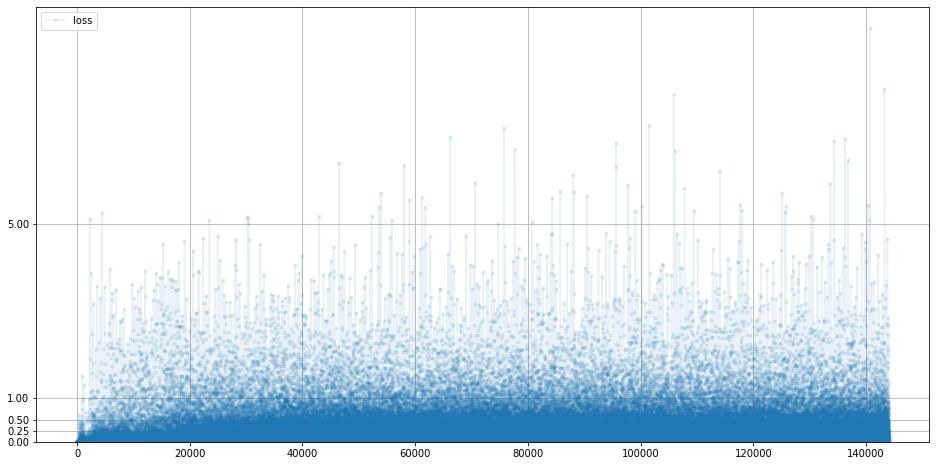

In [14]:
# plot discriminator error

D.plot_progress()

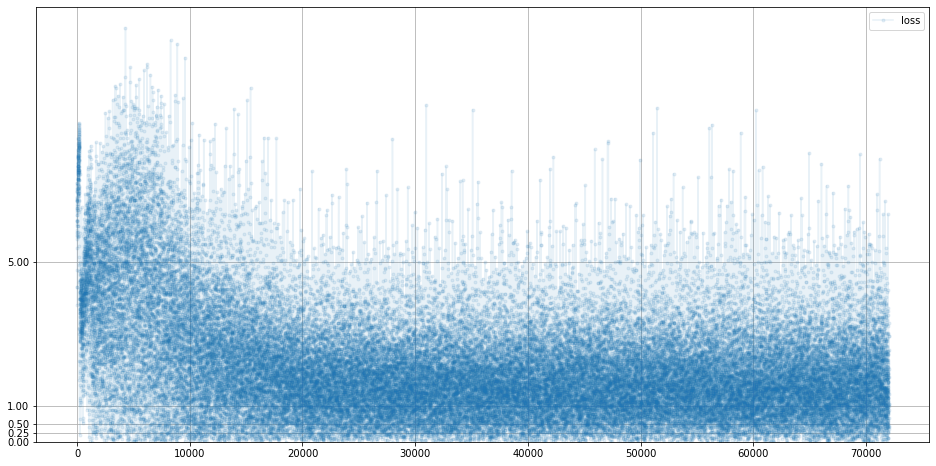

In [15]:
# plot generator error

G.plot_progress()

In [21]:
def plot_images(label):
    label_tensor = torch.zeros((10))
    label_tensor[label] = 1.0

    f, axrr = plt.subplots(2, 3, figsize=(16, 8))
    for i in range(2):
      for j in range(3):
        axrr[i, j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28, 28), interpolation='none', cmap='Blues')
        pass
      pass
    pass

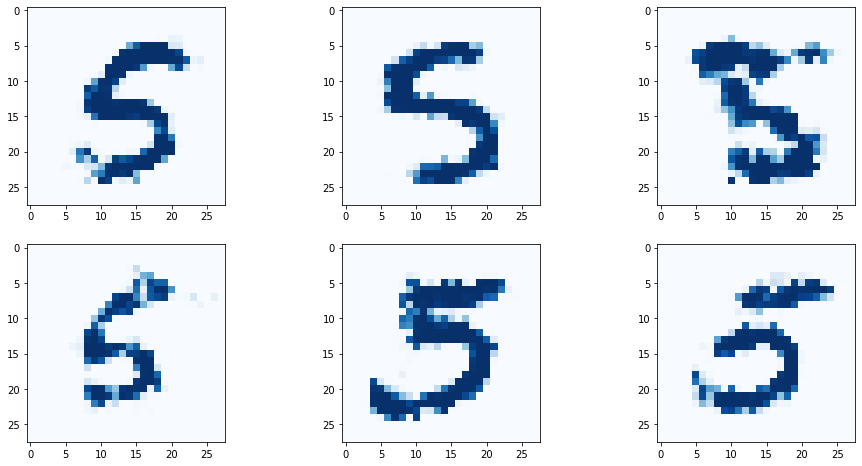

In [22]:
plot_images(5)

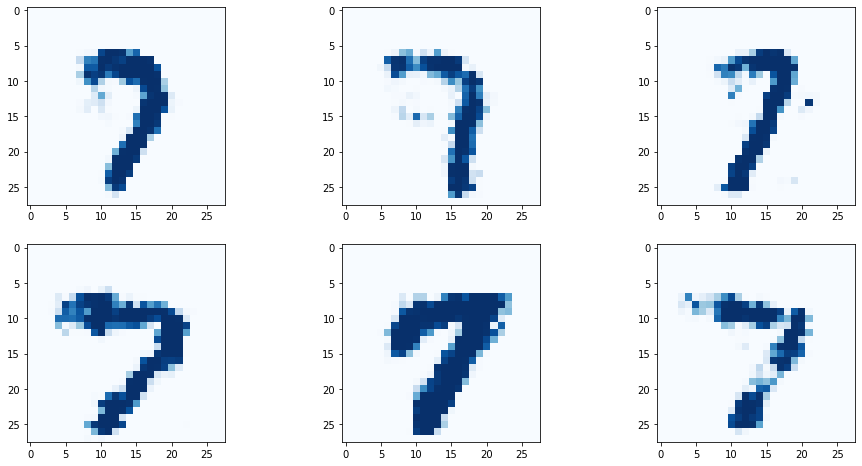

In [23]:
plot_images(7)

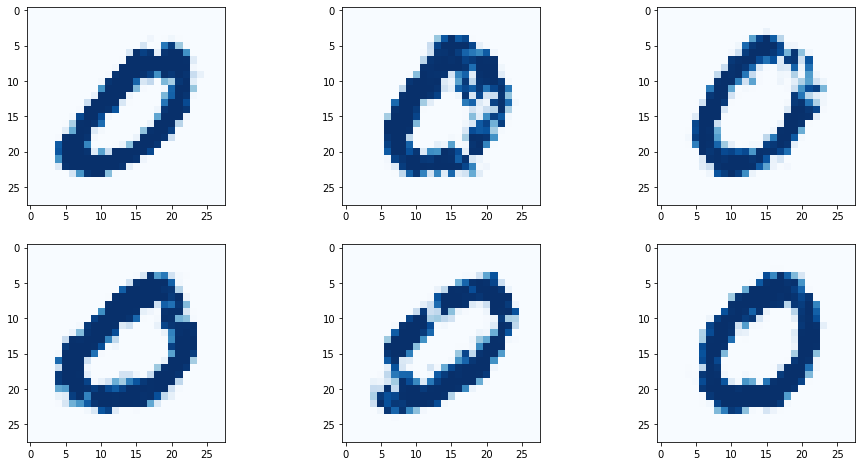

In [24]:
plot_images(0)

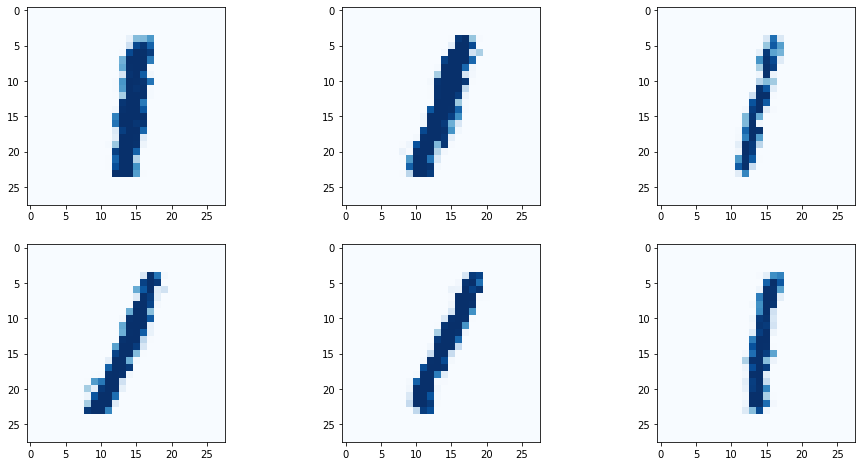

In [25]:
plot_images(1)

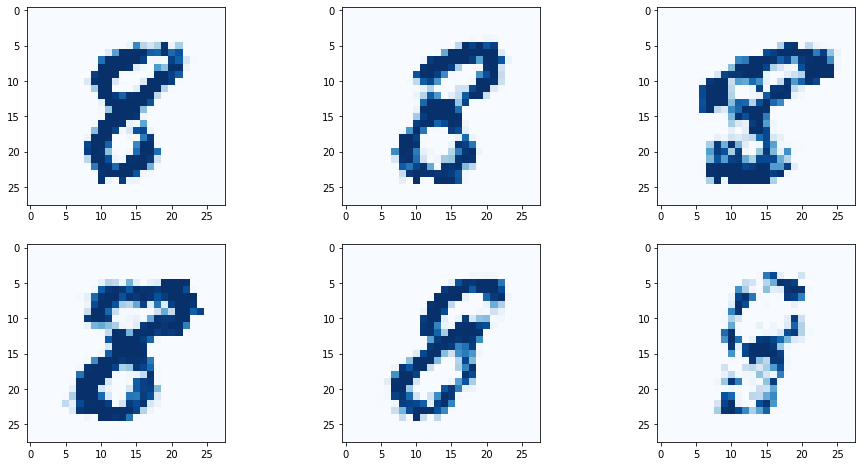

In [26]:
plot_images(8)